In [1]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

In [4]:
# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [9]:
import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict


# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO

from huggingface_hub import hf_hub_download

/mnt/SSD/user/shirakawa/projects/Grounded-Segment-Anything/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")
/mnt/SSD/user/shirakawa/projects/Grounded-Segment-Anything/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [10]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [11]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [18]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device='cpu')

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home/shirakawa/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


In [19]:
sam_checkpoint = '../segment-anything/test_SAM/sam_vit_h_4b8939.pth'
device ='cpu'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

In [27]:
import io


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

#  download_image(image_url, local_image_path)
local_image_path = 'assets/inpaint_demo.jpg'

In [28]:
TEXT_PROMPT = "dog"#"bench", "dog"]
TEXT_PROMPTs = ["bench", "dog"]
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

image_source, image = load_image(local_image_path)



In [110]:
image

tensor([[[ 0.6906,  0.7591,  0.8789,  ...,  1.6838,  1.6838,  1.6838],
         [ 0.6906,  0.7762,  0.8961,  ...,  1.6838,  1.6838,  1.6838],
         [ 0.7077,  0.7933,  0.9132,  ...,  1.6838,  1.6838,  1.6838],
         ...,
         [ 0.7933,  0.5536,  0.2111,  ..., -0.0629,  0.1426,  0.3138],
         [ 0.3823,  0.3652,  0.2796,  ..., -0.1828, -0.0629,  0.0398],
         [ 0.0227,  0.2282,  0.3652,  ..., -0.3712, -0.2856, -0.2513]],

        [[ 1.1856,  1.2381,  1.3256,  ...,  2.0259,  2.0259,  2.0259],
         [ 1.1856,  1.2556,  1.3431,  ...,  2.0259,  2.0259,  2.0259],
         [ 1.2031,  1.2731,  1.3606,  ...,  2.0259,  2.0259,  2.0259],
         ...,
         [ 0.8704,  0.6078,  0.2577,  ...,  0.0476,  0.2752,  0.4503],
         [ 0.4678,  0.4853,  0.3978,  ..., -0.0749,  0.0651,  0.1702],
         [ 0.1352,  0.3803,  0.5553,  ..., -0.2500, -0.1625, -0.1275]],

        [[ 1.5594,  1.6291,  1.7337,  ...,  2.3960,  2.3960,  2.3960],
         [ 1.5594,  1.6291,  1.7511,  ...,  2

In [44]:
image_base = image_source
for TEXT_PROMPT in TEXT_PROMPTs:
    
    boxes, logits, phrases = predict(
        model=groundingdino_model, 
        image=image, 
        caption=TEXT_PROMPT, 
        box_threshold=BOX_TRESHOLD, 
        text_threshold=TEXT_TRESHOLD, device='cpu'
    )

    annotated_frame = annotate(image_source=image_base, boxes=boxes, logits=logits, phrases=phrases)
    
    image_base = annotated_frame
annotated_frame = image_base # BGR to RGB

/home/shirakawa/miniconda3/envs/G_SAM/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


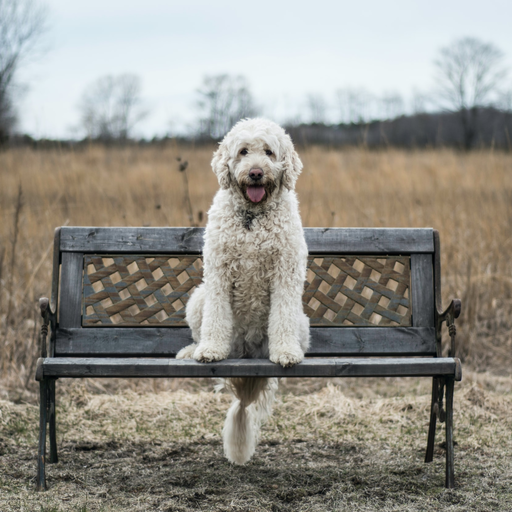

In [45]:
Image.fromarray(image_source)

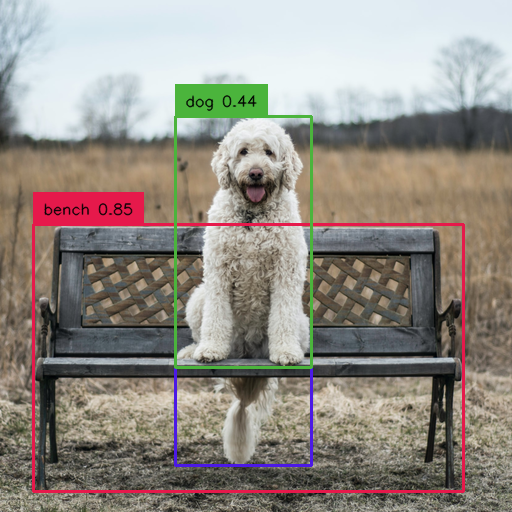

In [46]:
Image.fromarray(annotated_frame)

In [47]:
# set image
sam_predictor.set_image(image_source)

In [48]:
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

In [49]:
device ='cpu'
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )


In [88]:
np.concatenate([np.random.random(3), np.array([0.8])], axis=0)

array([0.21867279, 0.85374083, 0.96644079, 0.8       ])

In [50]:
def show_mask(mask, image, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)    
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [104]:
def show_mask_as_set_color(mask, image,Color):
    
    color = np.array([Color.b/255, Color.g/255, Color.r/255, 0.8])#np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [80]:
self_color.colors[0]

Color(r=230, g=25, b=75)

In [51]:
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)

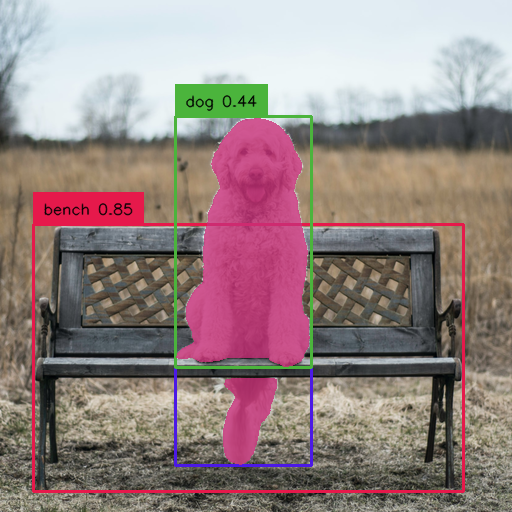

In [52]:
Image.fromarray(annotated_frame_with_mask)

In [61]:
from supervision.draw.color import Color, ColorPalette
self_color= ColorPalette.default()

In [107]:
image_base = image_source
# set image
sam_predictor.set_image(image_source)
idx = 0
for i, TEXT_PROMPT in enumerate(TEXT_PROMPTs):
    
    boxes, logits, phrases = predict(
        model=groundingdino_model, 
        image=image, 
        caption=TEXT_PROMPT, 
        box_threshold=BOX_TRESHOLD, 
        text_threshold=TEXT_TRESHOLD, device='cpu'
    )

    annotated_frame = annotate(image_source=image_base, boxes=boxes, logits=logits, phrases=phrases)
    
    
    
    # box: normalized box xywh -> unnormalized xyxy
    H, W, _ = image_source.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
    
    transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
    masks, _, _ = sam_predictor.predict_torch(
                point_coords = None,
                point_labels = None,
                boxes = transformed_boxes,
                multimask_output = False,
            )

    annotated_frame_with_mask = show_mask_as_set_color(masks[0][0], annotated_frame,self_color.colors[idx] )
    idx = idx + i+1#idx + len(boxes) +1
    #annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)
    image_base = annotated_frame_with_mask
annotated_frame = image_base # BGR to RGB

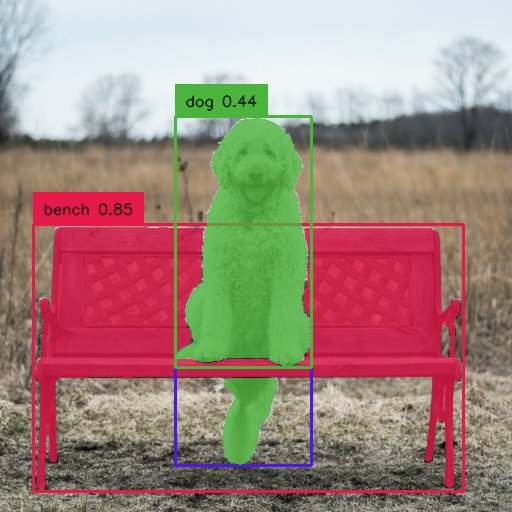

In [108]:
Image.fromarray(annotated_frame)

In [101]:
idx

3